In [24]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


commune=pd.read_parquet('donnee-comm-data.gouv-parquet-2023-geographie2024-produit-le2024-07-05.parquet')
dep=pd.read_csv('donnee-dep-data.gouv-2023-geographie2024-produit-le2024-07-05.csv',sep=';')
reg=pd.read_csv('donnee-reg-data.gouv-2023-geographie2024-produit-le2024-07-05.csv',sep=';')
commune.tail(10)

,CODGEO_2024,annee,classe,unité.de.compte,valeur.publiée,faits,tauxpourmille,complementinfoval,complementinfotaux,POP,millPOP,LOG,millLOG
3917750,97617,23,Vols avec armes,infraction,diff,42.0,3.014210,NaN,NaN,13934,17,3872.0,17
3917751,97617,23,Vols violents sans arme,infraction,diff,14.0,1.004737,NaN,NaN,13934,17,3872.0,17
3917752,97617,23,Vols sans violence contre des personnes,victime entendue,diff,53.0,3.803646,NaN,NaN,13934,17,3872.0,17
3917753,97617,23,Cambriolages de logement,infraction,diff,28.0,7.231405,NaN,NaN,13934,17,3872.0,17
3917754,97617,23,Vols de véhicules,véhicule,diff,26.0,1.865939,NaN,NaN,13934,17,3872.0,17
3917755,97617,23,Vols dans les véhicules,véhicule,diff,19.0,1.363571,NaN,NaN,13934,17,3872.0,17
3917756,97617,23,Vols d'accessoires sur véhicules,véhicule,ndiff,NaN,NaN,2.733333,0.234555,13934,17,3872.0,17
3917757,97617,23,Destructions et dégradations volontaires,infraction,diff,87.0,6.243720,NaN,NaN,13934,17,3872.0,17
3917758,97617,23,Trafic de stupéfiants,Mis en cause,ndiff,NaN,NaN,2.500000,0.216122,13934,17,3872.0,17
3917759,97617,23,Usage de stupéfiants,Mis en cause,ndiff,NaN,NaN,7.500000,0.673906,13934,17,3872.0,17


# I) Nettoyage des données dans les différents DataFrames
## A) Vérification de la cohérence et de l'uniformité des données
### 1) Vérification de la cohérence
Tout d'abord, il convient de vérifier que chaque variable est au bon type. L'objectif est d'avoir une uniformité des types de valeurs entre les 3 DataFrames commune, dep et reg. 
A noter que les dates seront traitées séparément car elles font l'objet d'une traitement particulier


In [25]:
## DataFrame commune
#les colonnes classe et unité.de.compte doivent être au format object
commune['classe']=commune['classe'].astype('str')
commune['unité.de.compte']=commune['unité.de.compte'].astype('str')
commune.info()
## DataFrame dep
dep.info()
## DataFrame reg
reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3917760 entries, 0 to 3917759
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   CODGEO_2024         object 
 1   annee               int32  
 2   classe              object 
 3   unité.de.compte     object 
 4   valeur.publiée      object 
 5   faits               float64
 6   tauxpourmille       float64
 7   complementinfoval   float64
 8   complementinfotaux  float64
 9   POP                 int32  
 10  millPOP             int32  
 11  LOG                 float64
 12  millLOG             int32  
dtypes: float64(5), int32(4), object(4)
memory usage: 328.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12928 entries, 0 to 12927
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   classe            12928 non-null  object
 1   annee             12928 non-null  int64 
 2   Code.département  12928 non-nu

### 2) Vérification de l'uniformité des données
Il convient de vérifier que les données sont uniformes, c'est à dire qu'elles doivent être écrites toujours de la même manière en respectant une règle unique
#### a) Données quantitatives

In [26]:
reg.head(1)

,classe,annee,Code.région,unité.de.compte,millPOP,millLOG,faits,POP,LOG,tauxpourmille
0,Homicides,16,1,victime,16,16,32,394110,"226105,0475677566","0,08119560528786381"


In [27]:
## DataFrame commune
commune['annee'].unique() #Toutes les années sont écrites au même format
commune['classe'].unique() #Toutes les classes sont écrites au même format et il n'y en a pas deux identiques écrites différemment 
commune['unité.de.compte'].unique() #Ici victime et victime entendue correspondent a la même unité de compte. Il faut donc modifier cela 
commune['unité.de.compte']=commune['unité.de.compte'].replace('victime entendue','victime')
commune['valeur.publiée'].unique() #Toutes les valeurs publiées sont écrites au même format 

## DataFrame dep
dep['annee'].unique() #Toutes les années sont écrites au même format
dep['classe'].unique() #Toutes les années sont écrites au même format
dep['Code.département'].unique() #Tous les départements sont écrits au même format sans erreur de doublon. A noter qu'il est normal que la valeur "20" soit manquante puisqu'il s'agit de la corse, dont le code a été remplacé en 1976 par 2A et 2B
dep['unité.de.compte'].unique() #Ici victime et victime entendue correspondent a la même unité de compte. Il faut donc modifier cela 
dep['unité.de.compte']=dep['unité.de.compte'].replace('victime entendue','victime')

## DataFrame reg
reg['annee'].unique() #Toutes les années sont écrites au même format
reg['classe'].unique() #Toutes les années sont écrites au même format
reg['Code.région'].unique() #Toutes les régions sont présentes et sont écrites au même format 

array([ 1,  2,  3,  4,  6, 11, 24, 27, 28, 32, 44, 52, 53, 75, 76, 84, 93,
       94])

#### b) Dates
L'étude des formats a démontré que les dates (ici "annee") sont au format int, ce qui est incorrect. Pour la suite de l'analyse, ces variables doivent être au format datetime64. 

In [28]:
commune['annee'] = pd.to_datetime(commune['annee'].apply(lambda x: f"20{x:02d}"))
dep['annee'] = pd.to_datetime(dep['annee'].apply(lambda x: f"20{x:02d}"))
reg['annee'] = pd.to_datetime(reg['annee'].apply(lambda x: f"20{x:02d}"))

## B) Vérifications des doublons

In [29]:
# Recherche de doublons 
print('Il y a',commune.duplicated().sum(),'doublons dans le df commune')
print('Il y a',dep.duplicated().sum(),'doublons dans le df dep')
print('Il y a',reg.duplicated().sum(),'doublons dans le df reg')

Il y a 0 doublons dans le df commune
Il y a 0 doublons dans le df dep
Il y a 0 doublons dans le df reg


## C) Vérification des valeurs manquantes
### 1) Analyse globale

In [30]:
# Recherche de valeurs manquantes du df departement 
print('Il y a',dep.isna().any(axis = 0).sum(),'colonnes contenant des valeurs manquantes dans le df departement')
# Recherche de valeurs manquantes sur les lignes du df département
#dep.isna().any(axis = 1).sum() Inutile donc 

Il y a 0 colonnes contenant des valeurs manquantes dans le df departement


In [31]:
# Recherche de valeurs manquantes du df région
print('Il y a',reg.isna().any(axis = 0).sum(),'colonnes contenant des valeurs manquantes dans le df reg')
# Recherche de valeurs manquantes sur les lignes du df régions
#reg.isna().any(axis = 1).sum() Inutile donc 

Il y a 0 colonnes contenant des valeurs manquantes dans le df reg


In [32]:
# Recherche de valeurs manquantes sur les colonnes du df commune
print('Il y a',commune.isna().any(axis = 0).sum(),'colonnes contenant des valeurs manquantes dans le df commune') 
# Recherche de valeurs manquantes sur les lignes du df communes
print('Il y a',commune.isna().any(axis = 1).sum(),'lignes contenant des valeurs manquantes sur',commune.shape[0],'lignes sur le df.')
print('Les colonnes concernées sont les colonnes faits, taux pour mille, complementinfoval, complementinfototaux')

Il y a 4 colonnes contenant des valeurs manquantes dans le df commune
Il y a 3917760 lignes contenant des valeurs manquantes sur 3917760 lignes sur le df.
Les colonnes concernées sont les colonnes faits, taux pour mille, complementinfoval, complementinfototaux


### 2) Traitement des valeurs manquantes
Le fichier des métadonnées du dataset indique que si la variable contenue dans la colonne "valeur.publiée" vaut ndiff, alors les variables contenues dans la colonne "faits" et "tauxpourmille" ne seront pas renseignées. De ce fait, il a été décidé de supprimer toutes les lignes donc la colonne "valeur.publiée" vaut ndiff. 

In [33]:
#Suppression des valeurs manquantes dans la colonne "faits"
commune.loc[commune['valeur.publiée'] == 'ndiff', 'faits'] = 0.0

#Suppression des valeurs manquantes dans la colonne "tauxpourmille"
commune.loc[commune['valeur.publiée'] == 'ndiff', 'tauxpourmille'] = 0.0
commune.isna().any(axis = 0)
#On  observe qu'il reste des NaN. On les localise et on étudie
commune.loc[commune[['tauxpourmille']].isna().any(axis=1)]
#Les NAN restants peuvent être recalculés car le taux pour mille est le nombre de faits divisé par millpop 
commune['millPOP'].unique() #On vérifie que millPOP ne prend pas la valeur 0 auquel cas la division serait impossible 
commune['tauxpourmille']=commune['tauxpourmille'].fillna(commune['faits']/commune['millPOP'])
commune.isna().any(axis = 0)
#Les colonnes "complementinfoval" et "complementinfototaux" contiennent encore des NaN mais ne sont pas utiles pour l'étude. 


CODGEO_2024           False
annee                 False
classe                False
unité.de.compte       False
valeur.publiée        False
faits                 False
tauxpourmille         False
complementinfoval      True
complementinfotaux     True
POP                   False
millPOP               False
LOG                   False
millLOG               False
dtype: bool

Certaines colonnes ne sont pas utiles pour cette étude. Il convient donc de les supprimer. 
Si dans le futur il s'avère qu'il est nécessaire de les garder, il suffira de supprimer la cellule suivante. L'argument inplace est laissé a sa valeur par défaut (false)

In [34]:
## DataFrame commune
commune=commune.drop("complementinfoval", axis=1)
commune=commune.drop("complementinfotaux", axis=1)
commune=commune.drop("LOG", axis=1)
commune=commune.drop("millLOG", axis=1)
## DataFrame reg
reg=reg.drop("LOG", axis=1)
reg=reg.drop("millLOG", axis=1)
## DataFrame dep
dep=dep.drop("LOG", axis=1)
dep=dep.drop("millLOG", axis=1)




## D) Autres préprocessings
Renommage des colonnes pour une meilleure lisibilité et faciliter les prochains devs 

In [35]:
## DataFrame commune
dictionnaire = {'CODGEO_2024': 'codgeo',
                'unité.de.compte': 'cible',
                'valeur.publiée': 'publication',
                'POP':'pop',
                'millPOP':'millpop'}
commune=commune.rename(dictionnaire, axis = 1) 
## DataFrame reg
dictionnaire = {'Code.région': 'region',
                'unité.de.compte': 'cible',
                'POP':'pop',
                'millPOP':'millpop'}
reg=reg.rename(dictionnaire, axis = 1)
## DataFrame dep
dictionnaire = {'Code.département': 'departement',
                'Code.région': 'region',
                'unité.de.compte': 'cible',
                'POP':'pop',
                'millPOP':'millpop'}
dep=dep.rename(dictionnaire, axis = 1)
#dep.head(1)

Les codes des départements et des régions ne sont que très peu parlants. Afin de faciliter le post-processing des études, il convient de remplacer les codes par leur nom complet. 

In [36]:
## DataFrame reg
#L'idée est ici de créer un dictionnaire clé-valeur issu d'un json (source dans le fichier README) pour "traduire" le code dans le nom de la région
json_cles_reg=pd.read_json('anciennes-nouvelles-regions.json')
dico_reg=json_cles_reg.set_index('new_code')['region'].to_dict()
reg['region']=reg['region'].map(dico_reg)
reg.tail(10)

,classe,annee,region,cible,millpop,faits,pop,tauxpourmille
2294,Usage de stupéfiants,2023-01-01,NORMANDIE,Mis en cause,21,12903,3327966,"3,87714297561934229"
2295,Usage de stupéfiants,2023-01-01,HAUTS DE FRANCE,Mis en cause,21,23724,5995292,"3,95710500839658863"
2296,Usage de stupéfiants,2023-01-01,GRAND EST,Mis en cause,21,14440,5561287,"2,59652127286363754"
2297,Usage de stupéfiants,2023-01-01,PAYS DE LA LOIRE,Mis en cause,21,8537,3853999,"2,21510176831908856"
2298,Usage de stupéfiants,2023-01-01,BRETAGNE,Mis en cause,21,8551,3394567,"2,51902525417822076"
2299,Usage de stupéfiants,2023-01-01,NOUVELLE AQUITAINE,Mis en cause,21,14637,6069352,"2,41162483243680725"
2300,Usage de stupéfiants,2023-01-01,OCCITANIE,Mis en cause,21,21171,6022176,"3,51550668728379900"
2301,Usage de stupéfiants,2023-01-01,AUVERGNE RHONE ALPES,Mis en cause,21,28978,8114361,"3,57119926017587819"
2302,Usage de stupéfiants,2023-01-01,PROVENCE ALPES COTE D AZUR,Mis en cause,21,37290,5127840,"7,27206777122531101"
2303,Usage de stupéfiants,2023-01-01,CORSE,Mis en cause,21,849,347597,"2,44248368081427625"


In [37]:
## DataFrame dep 
#On commence par modifier comme précédemment les codes des régions par leur nom 
dep['region']=dep['region'].map(dico_reg)
#Ensuite il va falloir créer un nouveau dictionnaire clé-valeur avec un fichier csv (source dans le fichier README)
csv_cles_dep=pd.read_csv('georef-france-departement.csv',sep = ';')
dico_dep=csv_cles_dep.set_index('Code Officiel Département')['Nom Officiel Département Majuscule'].to_dict()
dep['departement']=dep['departement'].map(dico_dep)
dep.head()

,classe,annee,departement,region,cible,millpop,faits,pop,tauxpourmille
0,Homicides,2016-01-01,AIN,AUVERGNE RHONE ALPES,victime,16,5,638425,"7,83177350511023e-03"
1,Homicides,2016-01-01,AISNE,HAUTS DE FRANCE,victime,16,10,536136,"1,86519838249996e-02"
2,Homicides,2016-01-01,ALLIER,AUVERGNE RHONE ALPES,victime,16,4,339384,"1,17860594488839e-02"
3,Homicides,2016-01-01,ALPES DE HAUTE PROVENCE,PROVENCE ALPES COTE D AZUR,victime,16,2,162565,"1,23027711992126e-02"
4,Homicides,2016-01-01,HAUTES ALPES,PROVENCE ALPES COTE D AZUR,victime,16,0,141107,"0,00000000000000e+00"


In [38]:
## DataFrame commune 
csv_cles_com=pd.read_csv('v_commune_2024.csv')
dico_com=csv_cles_com.set_index('COM')['NCC'].to_dict()
commune['codgeo']=commune['codgeo'].map(dico_com)

commune.head(1)

,codgeo,annee,classe,cible,publication,faits,tauxpourmille,pop,millpop
0,ABERGEMENT CLEMENCIAT,2016-01-01,Coups et blessures volontaires,victime,ndiff,0.0,0.0,767,16


In [39]:
#Il convient de vérifier que les étapes précédentes n'ont pas généré de NaN 
print('Il y a',dep.isna().any(axis = 0).sum(),'colonnes contenant des valeurs manquantes dans le df departements')
print('Il y a',reg.isna().any(axis = 0).sum(),'colonnes contenant des valeurs manquantes dans le df regions')
print('Il y a',commune.isna().any(axis = 0).sum(),'colonnes contenant des valeurs manquantes dans le df communes')

Il y a 0 colonnes contenant des valeurs manquantes dans le df departements
Il y a 0 colonnes contenant des valeurs manquantes dans le df regions
Il y a 0 colonnes contenant des valeurs manquantes dans le df communes


In [40]:
#On peut renommer la colonne "codgeo" qui n'est plus représentatif des variables qu'elle contient
dictionnaire = {'codgeo': 'ville',
                }
commune=commune.rename(dictionnaire, axis = 1)
commune.head(1)


,ville,annee,classe,cible,publication,faits,tauxpourmille,pop,millpop
0,ABERGEMENT CLEMENCIAT,2016-01-01,Coups et blessures volontaires,victime,ndiff,0.0,0.0,767,16


## E) Statistiques exploratoires
# 1) Recherche, analyse et traitement des outliers 

In [50]:
commune.head()

,ville,annee,classe,cible,publication,faits,tauxpourmille,pop,millpop
0,ABERGEMENT CLEMENCIAT,2016-01-01,Coups et blessures volontaires,victime,ndiff,0.0,0.0,767,16
1,ABERGEMENT CLEMENCIAT,2016-01-01,Coups et blessures volontaires intrafamiliaux,victime,diff,0.0,0.0,767,16
2,ABERGEMENT CLEMENCIAT,2016-01-01,Autres coups et blessures volontaires,victime,ndiff,0.0,0.0,767,16
3,ABERGEMENT CLEMENCIAT,2016-01-01,Violences sexuelles,victime,diff,0.0,0.0,767,16
4,ABERGEMENT CLEMENCIAT,2016-01-01,Vols avec armes,infraction,diff,0.0,0.0,767,16


<Axes: xlabel='faits'>

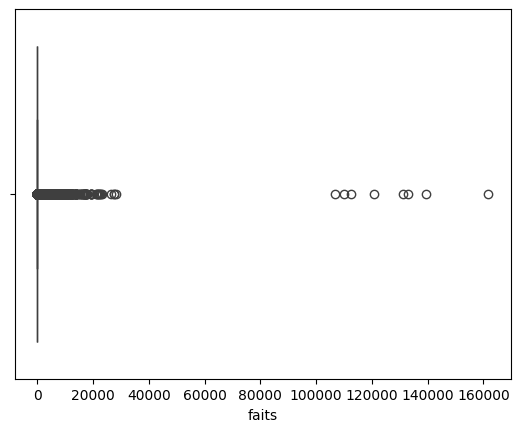

In [54]:
commune.describe()
#Il y a bien d'énormes outliers qu'il va falloir traiter
sns.boxplot(x = 'faits', data = commune)
#Valeurs aberrantes et valeurs extrêmes 

## F) Statistiques  

In [42]:
print(commune["ville"].value_counts(normalize=True)) #Pour savoir en pourcentage les villes les plus représentées 

ville
SAINTE COLOMBE    0.000343
SAINT SAUVEUR     0.000343
PIN               0.000286
BEAULIEU          0.000286
SAINT AUBIN       0.000286
                    ...   
ARANDAS           0.000029
ARBENT            0.000029
ARBIGNIEU         0.000029
ARBIGNY           0.000029
ARGIS             0.000029
Name: proportion, Length: 32464, dtype: float64
